In [15]:
!pip install natsort

Defaulting to user installation because normal site-packages is not writeable


In [93]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import random
import os
import glob
import natsort
import tensorflow as tf

from tqdm import trange
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from tensorflow.keras.layers import concatenate

from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [2]:
dir2018_path = '/home/gahee/ETRI/new/2018_user'
dir2019_path = '/home/gahee/ETRI/new/2019_user'
dir2020_path = '/home/gahee/ETRI/new/2020_user'

In [3]:
n_timesteps = 500
n_features = 4

In [4]:
users2018 = os.listdir(dir2018_path)
users2019 = os.listdir(dir2019_path)
users2020 = os.listdir(dir2020_path)

In [5]:
s2018 = pd.read_csv('user_survey_2018.csv', index_col=0)
s2019 = pd.read_csv('user_survey_2019.csv', index_col=0)
s2020 = pd.read_csv('user_survey_2020.csv', index_col=0)

In [6]:
# use glob to get all the csv files
# in the folder

def load_csv(dir_path, user):
    csv_files = glob.glob(os.path.join(dir_path, str(user),"*.csv"))

    df=[]

    # getting csv files from the folder MyProject
    path = "./102/"

    # read all the files with extension .csv
    # filenames = glob.glob(path + "/*.csv")
    filenames = natsort.natsorted(os.listdir(os.path.join(dir_path, str(user))))
    print('File names:', filenames)

    # for loop to iterate all csv files
    for file in filenames:
        # reading csv files
        df.append(pd.read_csv(os.path.join(dir_path, str(user), file),index_col=0))
        print("\nReading file = ",file)
        print(pd.read_csv(os.path.join(dir_path, str(user), file),index_col=0))
    
    return df

In [7]:
df = load_csv(dir2018_path, 1)

File names: ['1542244200_label.csv', '1542295920_label.csv', '1542471480_label.csv', '1542558180_label.csv', '1542728340_label.csv', '1542815760_label.csv', '1542902340_label.csv', '1543012320_label.csv', '1543275900_label.csv', '1543333680_label.csv']

Reading file =  1542244200_label.csv
             ts action  condition  emotionPositive  emotionTension
0    1542244200  study          3                4               6
1    1542244260  study          3                4               6
2    1542244320  study          3                4               6
3    1542244380  study          3                4               6
4    1542244440  study          3                4               6
..          ...    ...        ...              ...             ...
646  1542289980  study          2                4               6
647  1542290040  study          2                4               6
648  1542290100  study          2                4               6
649  1542290160  study          2      

In [8]:
# action 숫자로 대체
map_action = {'sleep':0, 'personal_care':1, 'work':2, 'study':2,'household':3, 'care_housemem':4\
             , 'recreation_media':5, 'entertainment':5, 'outdoor_act':5, 'hobby':5, \
              'recreation_etc':5, 'shop':5, 'communitiy_interaction':6, \
             'socialising':6,'travel':7, 'meal':8}
col = ['action']

In [9]:
# 길이 최솟값으로 행 자르기
# 필요없는 열 삭제

def df_min(df):
    new_df = df
    min = len(new_df[0]) 

    for i in range(len(new_df)):
        new_df[i].columns = new_df[i].columns.str.replace(' ', '')
        if (min>len(new_df[i])):
            min=len(new_df[i])

    for i in range(len(new_df)):
        new_df[i][col]=new_df[i][col].applymap(map_action.get)
        new_df[i]=new_df[i].iloc[:, 1:]

    for i in range(len(new_df)):
        new_df[i]=new_df[i].truncate(after=min-1,axis=0)  
#         print(len(new_df[i]))
    
    return new_df



In [10]:
df[0].head()

,ts,action,condition,emotionPositive,emotionTension
0,1542244200,study,3,4,6
1,1542244260,study,3,4,6
2,1542244320,study,3,4,6
3,1542244380,study,3,4,6
4,1542244440,study,3,4,6


In [17]:
# 일정 timestep 길이로 통일하기

def df_slice(df, num):
    new_df = df

    for i in range(len(new_df)):
        new_df[i].columns = new_df[i].columns.str.replace(' ', '')
        if (num>len(new_df[i])):
            num=len(new_df[i])

    for i in range(len(new_df)):
        new_df[i][col]=new_df[i][col].applymap(map_action.get)
        new_df[i]=new_df[i].iloc[:, 1:]

    for i in range(len(new_df)):
        new_df[i]=new_df[i].truncate(after=num-1,axis=0)  
#         print(len(new_df[i]))
    
    return new_df


In [54]:
new_df = df_min(df)
new_df[0].head()

,action,condition,emotionPositive,emotionTension
0,2,3,4,6
1,2,3,4,6
2,2,3,4,6
3,2,3,4,6
4,2,3,4,6


In [18]:
new_df = df_slice(df, n_timesteps)
new_df[0].head()

,action,condition,emotionPositive,emotionTension
0,2,3,4,6
1,2,3,4,6
2,2,3,4,6
3,2,3,4,6
4,2,3,4,6


In [53]:
def load_pmStress(survey_file, user):
    df2 = pd.read_csv(survey_file,index_col=0)
    df2=df2.drop(['sleep'],axis=1)
    df2=df2[df2['userId'] == user]
    pmStress=df2['pmStress']
    
    return pmStress
    

In [57]:
def load_Sleep(survey_file, user):
    df2 = pd.read_csv(survey_file,index_col=0)
    df2=df2[df2['userId'] == user]
    sleep = df2['sleep']
    
    return sleep
    

In [58]:
pmStress = load_pmStress("user_survey_2018.csv", 1)

In [59]:
sleep = load_Sleep("user_survey_2018.csv", 1)

In [22]:
ls

2018_user/  2020_user/  original/   user_survey_2018.csv  user_survey_2020.csv
2019_user/  new/        test.ipynb  user_survey_2019.csv


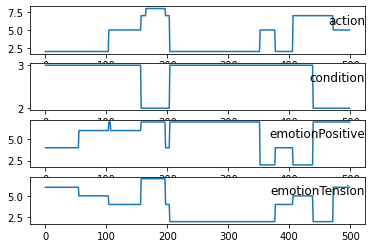

In [23]:
# 시각화
values = new_df[0].values
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
plt.figure()
for group in groups:
 plt.subplot(len(groups), 1, i)
 plt.plot(values[:, group])
 plt.title(new_df[0].columns[group], y=0.5, loc='right')
 i += 1
plt.show()

# Load data

1. 2018 data

In [38]:
def load_train_testdata(dfX1, dfX2, dfY):
  X1 = []
  X2 = [] 
  Y = []

  for i in range(10):
    X1.append(dfX1[i])
    X2.append(dfX2[i])
    Y.append(dfY[i])
  
  trainingX1 = np.array(X1[:8])
  trainingX2 = np.array(X2[:8])  
  trainingY = np.array(Y[:8])

  testX1 = np.array(X1[8:])
  testX2 = np.array(X2[8:])
  testY = np.array(Y[8:])

  return trainingX1, trainingX2, trainingY, testX1, testX2, testY




In [60]:
trainingX1, trainingX2, trainingY, testX1, testX2, testY = load_train_testdata(new_df, sleep, pmStress)

In [61]:
print(trainingX1.shape, trainingX2.shape, trainingY.shape)

(8, 500, 4) (8,) (8,)


# Model

### Multiple inputs

In [90]:
import tensorflow as tf

# from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from tensorflow.keras.layers import concatenate


from sklearn.preprocessing import MinMaxScaler

In [73]:
# first input model
ts_data = Input(shape=(n_timesteps,n_features))
lstm11 = LSTM(100, return_state=True)(ts_data)
drop11 = Dropout(0.5)(lstm11)
dense11 =  Dense(1)(drop11)
# second input model
sleep_data = Input(shape=(1))


# merge input models
merge = concatenate([dense11, sleep_data])
# interpretation model
hidden1 = Dense(5, activation='relu')(merge)
output = Dense(1, activation='softmax')(hidden1)
model = Model(inputs=[ts_data, sleep_data], outputs=output)
# summarize layers
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 500, 4)]     0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 100)          42000       input_5[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 100)          0           lstm_2[0][0]                     
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 1)            101         dropout_2[0][0]                  
____________________________________________________________________________________________

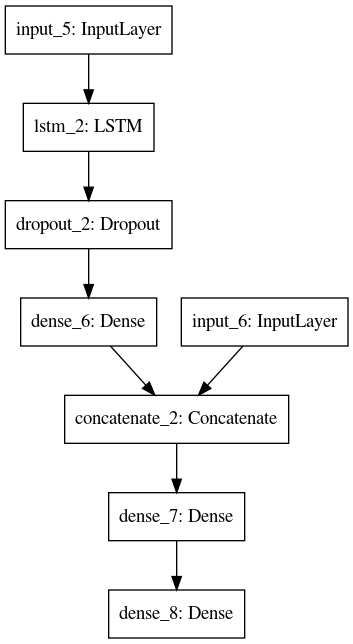

In [74]:
# plot graph
plot_model(model, to_file='multiple_inputs.png')

In [79]:
MAX_EPOCHS = 20


def compile_and_fit(model, train_X1, train_X2, train_y):
#   early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                     patience=patience,
#                                                     mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

  history = model.fit([train_X1, train_X2], train_y, epochs=MAX_EPOCHS)
  return history

In [80]:
history = compile_and_fit(model,trainingX1, trainingX2, trainingY)

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 2.1250 - accuracy: 0.2500
Epoch 2/20
1/1 [==============================] - 0s 251ms/step - loss: 2.1250 - accuracy: 0.2500
Epoch 3/20
1/1 [==============================] - 0s 232ms/step - loss: 2.1250 - accuracy: 0.2500
Epoch 4/20
1/1 [==============================] - 0s 236ms/step - loss: 2.1250 - accuracy: 0.2500
Epoch 5/20
1/1 [==============================] - 0s 209ms/step - loss: 2.1250 - accuracy: 0.2500
Epoch 6/20
1/1 [==============================] - 0s 248ms/step - loss: 2.1250 - accuracy: 0.2500
Epoch 7/20
1/1 [==============================] - 0s 243ms/step - loss: 2.1250 - accuracy: 0.2500
Epoch 8/20
1/1 [==============================] - 0s 220ms/step - loss: 2.1250 - accuracy: 0.2500
Epoch 9/20
1/1 [==============================] - 0s 209ms/step - loss: 2.1250 - accuracy: 0.2500
Epoch 10/20
1/1 [==============================] - 0s 214ms/step - loss: 2.1250 - accuracy: 0.2500
Epoch 11/20
1/1 [=====

In [83]:

# evaluate model
loss, accuracy = model.evaluate([testX1, testX2], batch_size=1, verbose=0)

In [84]:
print(loss, accuracy)

0.0 0.0


Text(0, 0.5, 'loss')

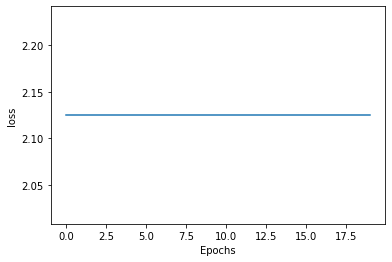

In [92]:

plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel('loss')


(0.0, 2.2418750000000003)

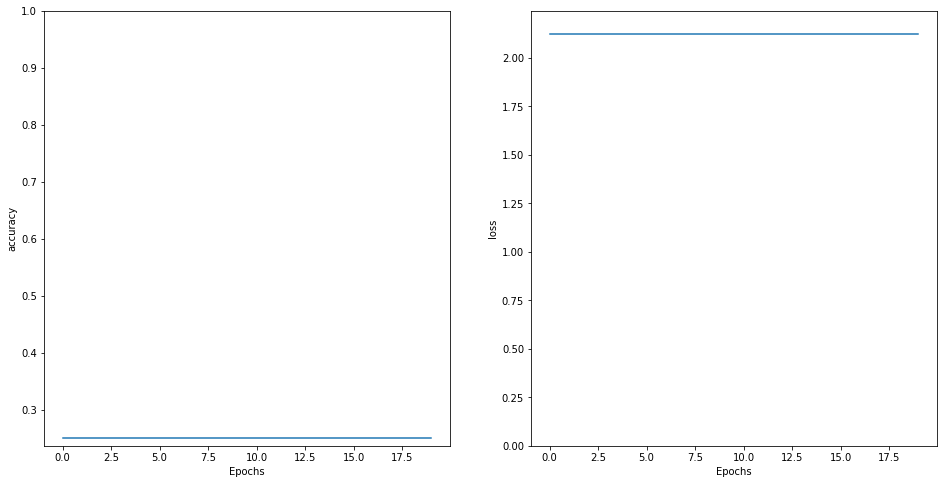

In [17]:
#2018
save2018 = []

for user in users2018:
    for i in range(0, s2018.shape[0]):
        row = s2018.iloc[i]
        if int(user) == row['userId']:
            for label in os.listdir(os.path.join(dir2018_path, user)):
                if (int(''.join(filter(str.isdigit, label)))==row['ts']):
                    save2018.append(os.path.join(dir2018_path, user,label))
                  

In [18]:
for user in users2018:
    if not os.path.exists(os.path.join(new_path, '2018_user',user)):
        os.makedirs(os.path.join(new_path, '2018_user',user))
    for i in range(0, s2018.shape[0]):
        row = s2018.iloc[i]
        if int(user) == row['userId']:
            for label in os.listdir(os.path.join(dir2018_path, user)):
                if (int(''.join(filter(str.isdigit, label)))==row['ts']):
                    shutil.copyfile(os.path.join(dir2018_path,user,label), os.path.join(new_path, '2018_user', user,label))


In [24]:
#2019
save2019 = []

for user in users2019:
    for i in range(0, s2019.shape[0]):
        row = s2019.iloc[i]
        if int(user) == row['userId']:
            for label in os.listdir(os.path.join(dir2019_path, user)):
                if (int(''.join(filter(str.isdigit, label)))==row['ts']):
                        save2019.append(os.path.join(dir2019_path, user,label))
        
    

In [25]:
for user in users2019:
    if not os.path.exists(os.path.join(new_path, '2019_user',user)):
        os.makedirs(os.path.join(new_path, '2019_user',user))
    for i in range(0, s2019.shape[0]):
        row = s2019.iloc[i]
        if int(user) == row['userId']:
            for label in os.listdir(os.path.join(dir2019_path, user)):
                if (int(''.join(filter(str.isdigit, label)))==row['ts']):
                    shutil.copyfile(os.path.join(dir2019_path,user,label), os.path.join(new_path, '2019_user', user,label))


In [104]:
#2020
save2020 = []

for user in users2020:
    for i in range(0, s2020.shape[0]):
        row = s2020.iloc[i]
        if int(''.join(filter(str.isdigit, user))) == row['userId']:
            for label in os.listdir(os.path.join(dir2020_path, user)):
                if (int(''.join(filter(str.isdigit, label)))==row['ts']):
                        save2020.append(os.path.join(dir2020_path, user,label))
        
    

In [28]:
for user in users2020:
    if not os.path.exists(os.path.join(new_path, '2020_user',user)):
        os.makedirs(os.path.join(new_path, '2020_user',user))
    for i in range(0, s2020.shape[0]):
        row = s2020.iloc[i]
        if int(''.join(filter(str.isdigit, user))) == row['userId']:
            for label in os.listdir(os.path.join(dir2020_path, user)):
                if (int(''.join(filter(str.isdigit, label)))==row['ts']):
                    shutil.copyfile(os.path.join(dir2020_path,user,label), os.path.join(new_path, '2020_user', user,label))


In [46]:
int(''.join(filter(str.isdigit, '200 grams')))

200

In [96]:
for file in os.listdir(os.path.join(dir2018_path,'1')):
    print(file)
    df_x = pd.read_csv(os.path.join(dir2018_path,'1',file), index_col=0, header=0)
    XX = np.append(X, np.array(df_x.iloc[:600, 2:]))

1543012320_label.csv
1542471480_label.csv
1542244200_label.csv
1542295920_label.csv
1542902340_label.csv
1542728340_label.csv
1542815760_label.csv
1543275900_label.csv
1542558180_label.csv
1543333680_label.csv
